In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns

### Description
Предскажите задержки вылета в 15 и более минут. Известно время вылета, авиакомпания-перевозчик, 
место вылета и назначения, а также расстояние между ними. Прогнозируемый признак – бинарный, целевая метрика – ROC AUC.

#### Признаки:
Month, DayofMonth, DayOfWeek, месяц, день месяца и день недели  
DepTime, время отправления  
UniqueCarrier, код перевозчика  
Origin, место вылета  
Dest, место назначения  
Distance, расстояние между аэропортами вылета и прилета  
dep_delayed_15min, просрочка вылета на 15 и более минут (целевой признак).

In [2]:
train = pd.read_csv(r"C:\Users\_Lenovo_\PycharmProjects\jupyter_rabota\flight-delays-2017\flight_delays_train.csv")
test = pd.read_csv(r"C:\Users\_Lenovo_\PycharmProjects\jupyter_rabota\flight-delays-2017\flight_delays_test.csv")
sample_submission = pd.read_csv(r"C:\Users\_Lenovo_\PycharmProjects\jupyter_rabota\flight-delays-2017\sample_submission.csv")

In [3]:
initial_shape_train = train.shape
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
initial_shape_test = test.shape
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [5]:
#Проверяем, есть ли в DataFrame пропуски
train.isna().any()

Month                False
DayofMonth           False
DayOfWeek            False
DepTime              False
UniqueCarrier        False
Origin               False
Dest                 False
Distance             False
dep_delayed_15min    False
dtype: bool

В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: DepTime и Distance.

In [6]:
X_train, y_train = (train[["DepTime", "Distance"]].values,
                    train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values,
)
X_test = test[["Distance", "DepTime"]].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=32
)

In [7]:
logit = LogisticRegression(random_state=32)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

In [8]:
roc_auc_score(y_valid, logit_valid_pred)

0.6877344133091989

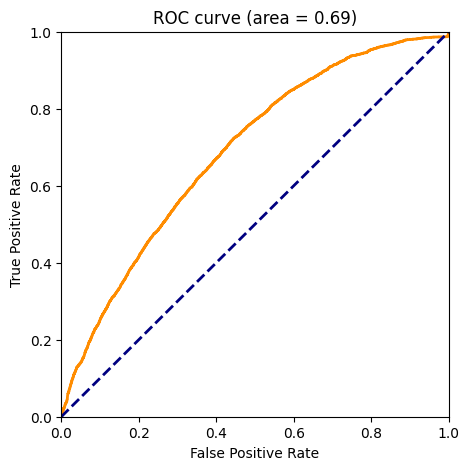

In [9]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_valid, logit_valid_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (area = {:.2f})'.format(roc_auc_score(y_valid, logit_valid_pred)))
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [10]:
# Копируем наши данные для дальнейшей работы, и оригинал данных оставляем неизменными.
X_train_new_features_cat = train.copy()
X_test_new_features_cat = test.copy()

# Создаём новый признак "маршрут" из места вылета в место назначения.
X_train_new_features_cat['Route'] = train['Origin'] + '_' + train['Dest']
X_train_new_features_cat['dep_delayed_15min'] = X_train_new_features_cat['dep_delayed_15min'].map({"Y": 1, "N": 0})
X_test_new_features_cat['Route'] = test['Origin'] + '_' + test['Dest']

In [11]:
# Смотрим на количество номинативных переменных.

X_train_new_features_cat.loc[:, X_train_new_features_cat.dtypes == 'object'].nunique()

Month              12
DayofMonth         31
DayOfWeek           7
UniqueCarrier      22
Origin            289
Dest              289
Route            4429
dtype: int64

Далее решаем путём "One-Hot Encoding" видоизменить наши номинативные признаки, все, кроме признака "Route".
Уникальных переменных в признаке "Route" многовато, будем использовать технику кодирования категориальных признаков 
средним значением целевого признака (Mean Target). Основная идея – для каждого значения категориального признака 
посчитать среднее значение целевого признака и заменить категориальный признак на посчитанные средние. 
Правда, считать средние надо на кросс-валидации, а то легко переобучиться.

In [12]:
# Считаем ожидаемое количество признаков, в конце +1 это признак Route.

counted_features = (sum(X_train_new_features_cat.drop(['Route'], axis=1).loc[:, X_train_new_features_cat.dtypes == 'object'].
                        nunique().values)
                        + len(X_train_new_features_cat.loc[:, X_train_new_features_cat.dtypes != 'object'].
                              drop(['dep_delayed_15min'], axis=1).nunique().values)+1)
counted_features

653

In [13]:
# Преобразуем номинативные признаки, бинаризация категориальных признаков (One-Hot Encoding).

X_train_new_features = pd.get_dummies(X_train_new_features_cat, columns=['Month','DayofMonth','DayOfWeek','UniqueCarrier','Origin','Dest'])
X_train_new_features.loc[:, X_train_new_features.dtypes == bool] = (X_train_new_features.loc
                                                                [:, X_train_new_features.dtypes == bool].astype(int)
)

In [14]:
# Проверяем если ожидаемое количество признаков совпадает с фактическим.

X_train_new_features.drop(['dep_delayed_15min'], axis=1).shape[1] == counted_features

True

In [15]:
# Делим наши данные на test и valid.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
y_train_new_features = X_train_new_features["dep_delayed_15min"]

X_train_new_features_part, X_valid_new_features_part, y_train_new_features_part, y_valid_new_features_part = train_test_split(
    X_train_new_features.drop("dep_delayed_15min", axis=1),
    y_train_new_features,
    test_size=0.3,
    stratify=y_train_new_features,
    random_state=32
)
X_train_new_features_part.shape

(70000, 653)

In [16]:
# Создаём нашу функцию для кодирования номинативных признаков (Mean Target).

def mean_target_enc(train_df, y_train, valid_df, skf):
    import warnings
    warnings.filterwarnings("ignore")
    
    if type(train_df) == pd.core.series.Series:
        train_df = pd.DataFrame({train_df.name : train_df})
    if type(valid_df) == pd.core.series.Series:
        valid_df = pd.DataFrame({valid_df.name : valid_df})
        
    glob_mean = y_train.mean()
    new_train_df = pd.concat([train_df, pd.Series(y_train, name="y")], axis=1)
    cat_features = new_train_df.columns[new_train_df.dtypes == "object"].tolist()

    for col in cat_features:
        new_train_df[col + "_mean_target"] = [
            glob_mean for _ in range(new_train_df.shape[0])
        ]
    
    for col in cat_features:
        means = valid_df[col].map(new_train_df.groupby(col)["y"].mean())
        valid_df[col + "_mean_target"] = means.fillna(glob_mean)
    valid_df.drop(cat_features, axis=1, inplace=True)
   

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = (
            new_train_df.iloc[train_idx, :],
            new_train_df.iloc[valid_idx, :],
        )

        for col in cat_features:
            means = valid_df_cv[col].map(train_df_cv.groupby(col)["y"].mean())
            valid_df_cv[col + "_mean_target"] = means.fillna(glob_mean)

        new_train_df.iloc[valid_idx] = valid_df_cv

    new_train_df.drop(cat_features + ["y"], axis=1, inplace=True)
    return new_train_df, valid_df

In [17]:
# Кодируем с помощью Mean Target только один признак "Route".

train_mean_target_part, valid_mean_target = mean_target_enc(
    X_train_new_features_part["Route"], y_train_new_features_part, X_valid_new_features_part["Route"], skf
)

In [18]:
# Заменяем исходный признак на наш видоизменённый признак.

X_train_new_features_part["Route"] = train_mean_target_part
X_valid_new_features_part["Route"] = valid_mean_target

In [19]:
# Проверяем на всякий случай, если ничего не потеряли из признаков, или не добавили как-то.

X_train_new_features_part.shape[1] == X_valid_new_features_part.shape[1] == counted_features

True

In [42]:
# Готовим параметры для первой модели "GridSearchCV" с XGBoost.

params = {"max_depth": range(4,8), "subsample":[0.6,1], 'reg_lambda': [0.01, 0.1, 1, 10]}
xgb_sklearn_model = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", random_state=32)

In [27]:
grid_search_cv = GridSearchCV(xgb_sklearn_model, param_grid=params, cv=skf, n_jobs=-1)

In [28]:
%%time
grid_search_cv.fit(X_train_new_features_part, y_train_new_features_part)

CPU times: total: 8min 32s
Wall time: 37min 52s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(4, 8),
                         'reg_lambda': [0.01, 0.1, 1, 10],
                         'subsample': [0.6, 1]})

In [29]:
grid_search_cv.best_params_

{'max_depth': 7, 'reg_lambda': 1, 'subsample': 1}

In [31]:
predicted_xgb = grid_search_cv.best_estimator_.predict_proba(X_valid_new_features_part)
roc_auc_score(y_valid_new_features_part, predicted_xgb[:,1])

0.731843033254146

In [35]:
# Пробуем улучшить модель с помощью лучшего подбора регуляризатора

params_2 = {'reg_lambda': [0.5, 2, 5]}
xgb_sklearn_model_2 = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", random_state=32
                                 , max_depth=7, subsample=1)

In [36]:
grid_search_cv_2 = GridSearchCV(xgb_sklearn_model_2, param_grid=params_2, cv=skf, n_jobs=-1)

In [37]:
%%time
grid_search_cv_2.fit(X_train_new_features_part, y_train_new_features_part)

CPU times: total: 1min 36s
Wall time: 3min 50s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1, param_grid={'reg_lambda': [0.5, 2, 5]})

In [40]:
grid_search_cv_2.best_params_

{'reg_lambda': 2}

In [41]:
predicted_xgb_2 = grid_search_cv_2.best_estimator_.predict_proba(X_valid_new_features_part)
roc_auc_score(y_valid_new_features_part, predicted_xgb_2[:,1])

0.7335456582849105

Видим что дальнейшая оптимизация регуляризатора не даёт сильного эффекта, пробуем подрезать наши деревья
с помощью регуляризатора "gamma", и посмотрим какой эффект это действие даст.

In [46]:
params_3 = {"gamma":[0.1,0.5,1,5,50]}
xgb_sklearn_model_3 = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", random_state=32
                                 , max_depth=7, subsample=1, reg_lambda=2)

In [47]:
grid_search_cv_3 = GridSearchCV(xgb_sklearn_model_3, param_grid=params_3, cv=skf, n_jobs=-1)

In [48]:
%%time
grid_search_cv_3.fit(X_train_new_features_part, y_train_new_features_part)

CPU times: total: 2min 4s
Wall time: 5min 31s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1, param_grid={'gamma': [0.1, 0.5, 1, 5, 50]})

In [49]:
grid_search_cv_3.best_params_

{'gamma': 1}

In [50]:
predicted_xgb_3 = grid_search_cv_3.best_estimator_.predict_proba(X_valid_new_features_part)
roc_auc_score(y_valid_new_features_part, predicted_xgb_3[:,1])

0.7341797877676839

In [43]:
# Итоговые параметры после поисков оптимальных вариантов на "XGBClassifier".
# (n_estimators=50, learning_rate=0.2) ещё нужно оптимизировать

xgb_sklearn_model_final = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", random_state=32
                                 , max_depth=7, subsample=1, reg_lambda=2, gamma=1)

In [20]:
params_xgb = {
    "booster": "gbtree",
    "max_depth": 7,
    "eta": 0.1,
    "silent": 1,
    "objective": "binary:logistic",
    "nthread": 2,
    "gamma" : 1,
    "lambda" : 2,
    "eval_metric":"auc",
    "seed":32
}
evals_result = {}
dtrain = xgb.DMatrix(X_train_new_features_part, y_train_new_features_part)
dvalid = xgb.DMatrix(X_valid_new_features_part, y_valid_new_features_part)

# По последним данным из списка будет срабатывать 'early_stopping_rounds', ставим 'valid', чтоб избежать переобучения.
watchlist = [(dtrain, "train"), (dvalid, "valid")]

In [22]:
%%time
# Ищем оптимальное количество итераций для XGBoost, чтоб оставить меньше шансов для переобучения.
# И для оптимизации работы алгоритма.

xgb_final = xgb.train(params_xgb, dtrain, num_boost_round=1500, evals = watchlist, 
                      evals_result = evals_result, early_stopping_rounds = 100, verbose_eval=100)

[0]	train-auc:0.71620	valid-auc:0.70089
[100]	train-auc:0.80296	valid-auc:0.73482
[200]	train-auc:0.82688	valid-auc:0.73759
[300]	train-auc:0.82835	valid-auc:0.73781
[303]	train-auc:0.82835	valid-auc:0.73781
CPU times: total: 2min 5s
Wall time: 1min 4s


In [23]:
xgb_best_iteration = xgb_final.best_iteration
xgb_best_iteration

203

In [24]:
evals_result['valid']['auc'][xgb_best_iteration]

0.7378422023738229

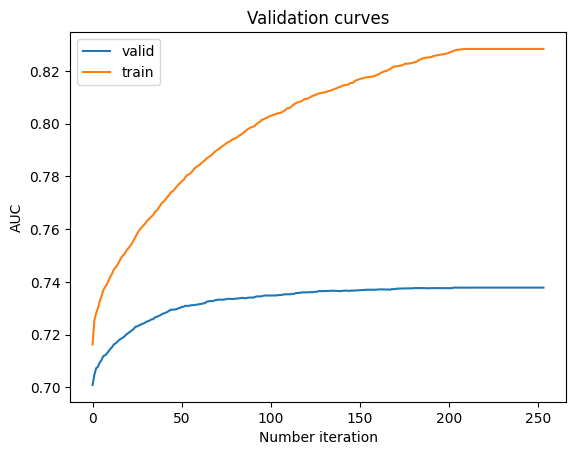

In [87]:
# Строим валидационные кривые, чтоб посмотреть на процесс обучения на train и на test

plt.plot(evals_result['valid']['auc'], label="valid")
plt.plot(evals_result['train']['auc'], label="train")
plt.legend(loc="best")
plt.xlabel('Number iteration')
plt.ylabel('AUC')
plt.title('Validation curves')
plt.show()

In [26]:
%%time
# Пробуем использовать алгоритм catboost с параметрами по умолчанию, и без нашего нового признака "Route"

(X_train_new_features_cat_part, X_valid_new_features_cat_part, 
 y_train_new_features_cat_part, y_valid_new_features_cat_part) = train_test_split(
    X_train_new_features_cat.drop(["dep_delayed_15min","Route"], axis=1),
    y_train_new_features,
    test_size=0.3,
    stratify=y_train_new_features,
    random_state=32
)

ctb = CatBoostClassifier(random_seed=32)
cat_features_idx = np.where(X_train_new_features_cat_part.dtypes == "object")[0].tolist()
ctb.fit(X_train_new_features_cat_part, y_train_new_features_cat_part, cat_features=cat_features_idx, metric_period=100)

Learning rate set to 0.063211
0:	learn: 0.6607142	total: 279ms	remaining: 4m 38s
100:	learn: 0.4249974	total: 20.6s	remaining: 3m 3s
200:	learn: 0.4167547	total: 42.6s	remaining: 2m 49s
300:	learn: 0.4107562	total: 1m 5s	remaining: 2m 32s
400:	learn: 0.4066072	total: 1m 28s	remaining: 2m 12s
500:	learn: 0.4026717	total: 1m 51s	remaining: 1m 51s
600:	learn: 0.3990550	total: 2m 15s	remaining: 1m 30s
700:	learn: 0.3958905	total: 2m 40s	remaining: 1m 8s
800:	learn: 0.3928478	total: 3m 4s	remaining: 45.8s
900:	learn: 0.3895698	total: 3m 28s	remaining: 22.9s
999:	learn: 0.3864095	total: 3m 54s	remaining: 0us
CPU times: total: 14min 2s
Wall time: 3min 56s


In [27]:
# Видим что catboost с параметрами с коробки справляется лучше чем XGBoost, но время на обучение занимает больше,
# из-за большего количества итераций.

roc_auc_score(y_valid_new_features_cat_part, ctb.predict_proba(X_valid_new_features_cat_part)[:, 1])

0.7603582548157578

In [28]:
%%time
# Пробуем теперь с нашим новым параметром "Route", и при этом меняем только его через параметр "cat_features".

(X_train_new_features_cat_part_2, X_valid_new_features_cat_part_2, 
y_train_new_features_cat_part_2, y_valid_new_features_cat_part_2) = train_test_split(
    X_train_new_features.drop("dep_delayed_15min", axis=1),
    y_train_new_features,
    test_size=0.3,
    stratify=y_train_new_features,
    random_state=32
)
ctb_2 = CatBoostClassifier(random_seed=32)
cat_features_idx_2 = np.where(X_train_new_features_cat_part_2.columns == "Route")[0].tolist()
ctb_2.fit(X_train_new_features_cat_part_2, y_train_new_features_cat_part_2, 
          cat_features=cat_features_idx_2, metric_period=100)

Learning rate set to 0.063211
0:	learn: 0.6594570	total: 202ms	remaining: 3m 21s
100:	learn: 0.4321837	total: 16.2s	remaining: 2m 24s
200:	learn: 0.4225817	total: 32.8s	remaining: 2m 10s
300:	learn: 0.4147692	total: 47.7s	remaining: 1m 50s
400:	learn: 0.4086934	total: 1m 4s	remaining: 1m 35s
500:	learn: 0.4036688	total: 1m 20s	remaining: 1m 20s
600:	learn: 0.3992972	total: 1m 36s	remaining: 1m 4s
700:	learn: 0.3951839	total: 1m 53s	remaining: 48.5s
800:	learn: 0.3913214	total: 2m 10s	remaining: 32.3s
900:	learn: 0.3877310	total: 2m 28s	remaining: 16.3s
999:	learn: 0.3844155	total: 2m 47s	remaining: 0us
CPU times: total: 8min 18s
Wall time: 2min 54s


In [155]:
# Стало хуже
roc_auc_score(y_valid_new_features_cat_part_2, ctb_2.predict_proba(X_valid_new_features_cat_part_2)[:, 1])

0.7451408769385925

In [29]:
%%time
# Теперь пробуем вместе с "Route" и при этом все категориальные признаки пропустить через параметр "cat_features".

(X_train_new_features_cat_part_3, X_valid_new_features_cat_part_3, 
y_train_new_features_cat_part_3, y_valid_new_features_cat_part_3) = train_test_split(
    X_train_new_features_cat.drop("dep_delayed_15min", axis=1),
    y_train_new_features,
    test_size=0.3,
    stratify=y_train_new_features,
    random_state=32
)

ctb_3 = CatBoostClassifier(random_seed=32)
cat_features_idx_3 = np.where(X_train_new_features_cat_part_3.dtypes == "object")[0].tolist()
ctb_3.fit(X_train_new_features_cat_part_3, y_train_new_features_cat_part_3, 
          cat_features=cat_features_idx_3, metric_period=100)

Learning rate set to 0.063211
0:	learn: 0.6619017	total: 94.3ms	remaining: 1m 34s
100:	learn: 0.4241715	total: 25.6s	remaining: 3m 47s
200:	learn: 0.4163148	total: 52.8s	remaining: 3m 30s
300:	learn: 0.4102121	total: 1m 21s	remaining: 3m 9s
400:	learn: 0.4057188	total: 1m 51s	remaining: 2m 47s
500:	learn: 0.4015315	total: 2m 22s	remaining: 2m 22s
600:	learn: 0.3979327	total: 2m 53s	remaining: 1m 55s
700:	learn: 0.3945390	total: 3m 25s	remaining: 1m 27s
800:	learn: 0.3912524	total: 3m 58s	remaining: 59.2s
900:	learn: 0.3880815	total: 4m 29s	remaining: 29.6s
999:	learn: 0.3851016	total: 5m	remaining: 0us
CPU times: total: 17min 54s
Wall time: 5min 3s


In [30]:
# Пока лучший результат.
roc_auc_score(y_valid_new_features_cat_part_3, ctb_3.predict_proba(X_valid_new_features_cat_part_3)[:, 1])

0.762890080910112

In [68]:
ctb_3_feature_importances = pd.DataFrame(ctb_3.feature_importances_, index=ctb_3.feature_names_, 
                                         columns=['feature_importances']).sort_values('feature_importances', 
                                                                                      ascending=False)
ctb_3_feature_importances

,feature_importances
DepTime,40.036483
UniqueCarrier,10.706679
Dest,8.282542
Origin,7.976791
Month,7.627197
Distance,7.178618
DayofMonth,6.699023
Route,5.944334
DayOfWeek,5.548331


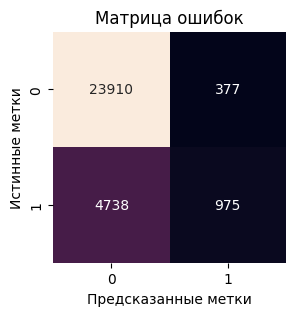

4738

In [113]:
conf_mat = confusion_matrix(y_valid_new_features_cat_part_3, ctb_3.predict(X_valid_new_features_cat_part_3))
plt.figure(figsize=[3,3])
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

In [109]:
np.bincount(y_train)

array([80956, 19044], dtype=int64)

In [33]:
%%time
# Видим что наш алгоритм предсказываем гораздо хуже классы 1, пробуем улучшить ситуацию с помощью весов для модели.
# И сразу оптимизируем алгоритм по количеству итераций.

eval_set = (X_valid_new_features_cat_part_3, y_valid_new_features_cat_part_3)
ctb_4 = CatBoostClassifier(random_seed=32, auto_class_weights='Balanced', early_stopping_rounds=100, eval_metric="AUC", 
                           metric_period=100, iterations=2000)
ctb_4.fit(X_train_new_features_cat_part_3, y_train_new_features_cat_part_3, cat_features=cat_features_idx_3, 
          eval_set=eval_set)

Learning rate set to 0.066942


0:	test: 0.6930752	best: 0.6930752 (0)	total: 345ms	remaining: 11m 29s
100:	test: 0.7428542	best: 0.7428584 (99)	total: 28.5s	remaining: 8m 55s
200:	test: 0.7495258	best: 0.7495565 (199)	total: 57.3s	remaining: 8m 32s
300:	test: 0.7537098	best: 0.7537098 (300)	total: 1m 30s	remaining: 8m 29s
400:	test: 0.7566591	best: 0.7567061 (396)	total: 2m 3s	remaining: 8m 11s
500:	test: 0.7584294	best: 0.7584294 (500)	total: 2m 37s	remaining: 7m 51s
600:	test: 0.7592919	best: 0.7593222 (595)	total: 3m 12s	remaining: 7m 27s
700:	test: 0.7607611	best: 0.7607611 (700)	total: 3m 47s	remaining: 7m 1s
800:	test: 0.7618305	best: 0.7619444 (783)	total: 4m 24s	remaining: 6m 35s
900:	test: 0.7622839	best: 0.7622839 (900)	total: 5m 1s	remaining: 6m 7s
1000:	test: 0.7625588	best: 0.7625588 (1000)	total: 5m 37s	remaining: 5m 36s
1100:	test: 0.7630789	best: 0.7630789 (1100)	total: 6m 14s	remaining: 5m 5s
1200:	test: 0.7635776	best: 0.7636547 (1192)	total: 6m 51s	remaining: 4m 33s
1300:	test: 0.7642503	best: 0.7

In [34]:
# Наш лучший результат
ctb_valid_predict = ctb_4.predict_proba(X_valid_new_features_cat_part_3)[:, 1]
roc_auc_score(y_valid_new_features_cat_part_3, ctb_valid_predict)

0.7646270406724084

In [151]:
# Видим что важность наших признаков более равномерней распределилась
ctb_4_feature_importances = pd.DataFrame(ctb_4.feature_importances_, index=ctb_4.feature_names_, 
                                         columns=['feature_importances']).sort_values('feature_importances', 
                                                                                      ascending=False)
ctb_4_feature_importances

,feature_importances
DepTime,30.119665
UniqueCarrier,10.955977
Dest,9.607299
Origin,9.519609
Distance,9.241380
Route,9.102014
Month,7.612624
DayofMonth,7.071274
DayOfWeek,6.770159


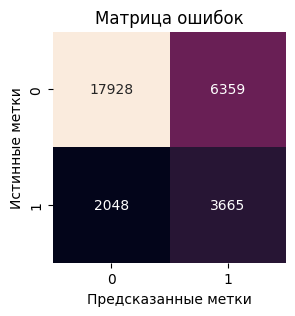

In [152]:
# И мы лучше начали предсказывать классы 1, чуть хуже классы 0 чем было.
# Но наш главный оптимизационный критерий "AUC" не пострадал, а только чуть прибавился.

conf_mat = confusion_matrix(y_valid_new_features_cat_part_3, ctb_4.predict(X_valid_new_features_cat_part_3))
plt.figure(figsize=[3,3])
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

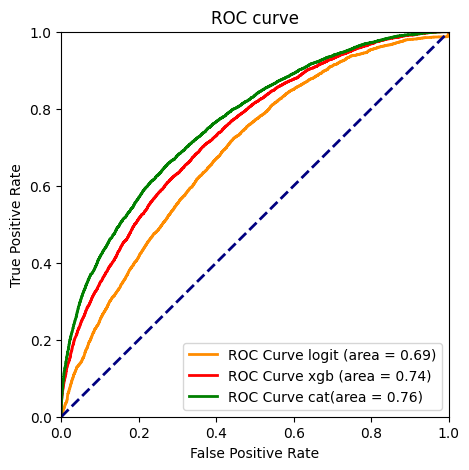

In [43]:
# Строим ROC-AUC для всех наших моделей

xgb_valid_predict = xgb_final.predict(dvalid)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_valid_new_features_part, xgb_valid_predict)
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_valid_new_features_cat_part_3, ctb_valid_predict)
plt.figure(figsize=(5, 5))
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label="ROC Curve logit (area = {:.2f})".
         format(roc_auc_score(y_valid, logit_valid_pred)))
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label="ROC Curve xgb (area = {:.2f})".
         format(roc_auc_score(y_valid_new_features_part, xgb_valid_predict)))
plt.plot(fpr_cat, tpr_cat, color='green', lw=2, label="ROC Curve cat(area = {:.2f})".
         format(roc_auc_score(y_valid_new_features_cat_part_3, ctb_valid_predict)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="best")
plt.show()

In [35]:
ctb_4_best_iteration = ctb_4.best_iteration_
ctb_4_best_iteration

1382

In [36]:
%%time
# Обучаем самый последний алгоритм для всех наших train данных, чтоб спрогнозировать test данные и отправить на Kaggle.

ctb_final = CatBoostClassifier(random_seed=32, auto_class_weights='Balanced', iterations=ctb_4_best_iteration)
ctb_final.fit(X_train_new_features_cat.drop("dep_delayed_15min", axis=1), y_train, 
              cat_features=cat_features_idx_3, metric_period=100)
result = ctb_final.predict_proba(X_test_new_features_cat)[:, 1]

Learning rate set to 0.054713
0:	learn: 0.6866805	total: 451ms	remaining: 10m 22s
100:	learn: 0.5951751	total: 41.6s	remaining: 8m 47s
200:	learn: 0.5855834	total: 1m 19s	remaining: 7m 49s
300:	learn: 0.5769924	total: 2m 1s	remaining: 7m 17s
400:	learn: 0.5705706	total: 2m 43s	remaining: 6m 40s
500:	learn: 0.5649915	total: 3m 26s	remaining: 6m 3s
600:	learn: 0.5598502	total: 4m 10s	remaining: 5m 25s
700:	learn: 0.5548183	total: 5m	remaining: 4m 52s
800:	learn: 0.5499589	total: 5m 50s	remaining: 4m 13s
900:	learn: 0.5451820	total: 6m 36s	remaining: 3m 31s
1000:	learn: 0.5407238	total: 7m 22s	remaining: 2m 48s
1100:	learn: 0.5366127	total: 8m 10s	remaining: 2m 5s
1200:	learn: 0.5327408	total: 8m 54s	remaining: 1m 20s
1300:	learn: 0.5286802	total: 9m 38s	remaining: 36s
1381:	learn: 0.5256408	total: 10m 14s	remaining: 0us
CPU times: total: 37min 14s
Wall time: 10min 22s


In [156]:
# функция для записи прогнозов в файл

def write_to_submission_file(
    predicted_labels, out_file="result.csv", target="dep_delayed_15min", index_label="id"
):
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(0, predicted_labels.shape[0]),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

In [160]:
write_to_submission_file(result)